In [1]:
from random import shuffle

import matplotlib.pyplot as plt
from ase.calculators.emt import EMT
from ase.cluster import Octahedron
from ase.visualize import view
from sklearn.linear_model import Ridge

from npl.calculators import TrainedCalculator
from npl.core import Nanoparticle as nano
from npl.descriptors import Topologies
from npl.global_optimization.operations import GuidedExchangeOperator
from npl.utils import (compute_bond_types,
                       compute_coefficients_for_linear_topological_model)

In [2]:
symbols = ['Au']*150+['Pt']*105+['Pd']*100+['Ni']*50
system = Octahedron('Pt', 9, 3)
system.calc = EMT()
training_set = []

for _ in range(4):
    shuffle(symbols)
    system.symbols = symbols
    system.get_potential_energy()
    p = nano.from_atoms(system)
    top = Topologies(p.get_unique_atomic_numbers())
    top.get_feature_vector(p)
    training_set.append(p)

c = TrainedCalculator('TOP', Ridge)
c.fit(training_set)
coef = c.get_coefficients()

In [3]:
import numpy as np
np.dot(np.transpose(c.model.coef_) ,p.descriptors['TOP'])

15.393832905202801

[-0.14247119  0.         -0.18122283 -0.02189623] [-0.31515266 -0.33818375  0.          0.11453547]


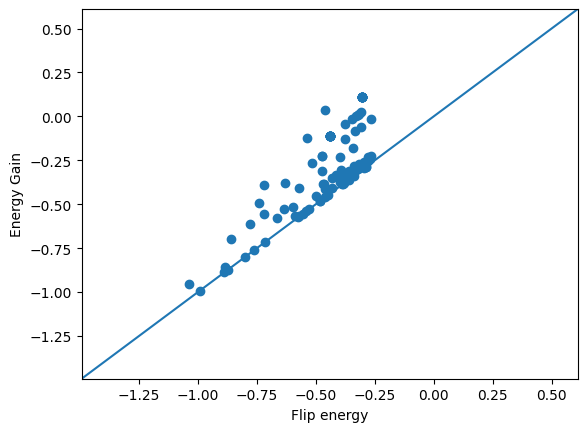

<Popen: returncode: None args: ['/home/riccardo/python_venvs/NPlib/bin/pytho...>

In [4]:
system.symbols = symbols

system.get_potential_energy()
p = nano.from_atoms(system)
view(p)
top = Topologies(p.get_unique_atomic_numbers())
top.get_feature_vector(p)
coefficients, total_energy, feature_index_values = compute_coefficients_for_linear_topological_model(coef, training_set[1].get_unique_atomic_numbers())
exchange = GuidedExchangeOperator(p, total_energy, feature_index_values)

a, b = exchange.find_best_swap_pair()[0]
print(exchange.exchange_energies[a] ,exchange.exchange_energies[b])

old_energy = c.calculate_total(p)

flips = []
gains = []
for _ in range(100):
    exchange = GuidedExchangeOperator(p, total_energy, feature_index_values)
    flip_energy = exchange.perform_operation(p)*2
    top.get_feature_vector(p)
    new_energy = c.calculate_total(p)
    energy_gain =  new_energy - old_energy
    old_energy = new_energy
    
    flips.append(flip_energy)
    gains.append(energy_gain)


plt.scatter(flips, gains)
plt.xlabel('Flip energy')
plt.ylabel('Energy Gain')
plt.xlim(min(gains)-0.5,max(gains)+0.5)
plt.ylim(min(gains)-0.5,max(gains)+0.5)
plt.plot([-10,10],[-10,10])
plt.show()
view(p)

In [5]:
flips[3], gains[3]

(-0.8861489007860398, -0.8590866122413203)

In [6]:
from npl.utils import compute_bond_combinations, compute_bond_types

bond_types = compute_bond_types(coef, exchange.atomic_numbers)
Z_i = 46
for bond_combination in compute_bond_combinations(3, 6):
    bond_energy = 0
    tot_energy = 0
    
    for n_bond, Z_j in zip(bond_combination, exchange.atomic_numbers):
        bond_type = tuple(sorted([Z_i, Z_j]))
        bond_energy += (n_bond/2) * bond_types[bond_type]

        tot_energy += bond_energy
        tot_energy += (n_bond/2) * bond_types[bond_type]

    if bond_energy != tot_energy:
        print(bond_energy, tot_energy)

-0.007946042888024897 -0.03178417155209959
0.005956101137749113 0.011246601006559925
-0.01471161502420427 -0.04266663486178336
0.019858245163523122 0.05427737356521943
-0.0008094709984302617 0.0003641376968761406
-0.021477187160383646 -0.05354909817146715
0.033760389189297135 0.09730814612387895
0.013092673027343746 0.04339491025553564
-0.007575043134609636 -0.010518325612807643
-0.02824275929656302 -0.06443156148115094
0.047662533215071134 0.14033891868253845
0.026994817053117758 0.08642568281419517
0.006327100891164374 0.03251244694585187
-0.01434061527078901 -0.021400788922491427
-0.035008331432742394 -0.07531402479083471
0.06156467724084514 0.18336969124119792
0.040896961078891764 0.12945645537285466
0.020229244916938383 0.07554321950451137
-0.0004384712450150041 0.021629983636168082
-0.02110618740696838 -0.03228325223217521
-0.041773903568921765 -0.0861964881005185
0.07546682126661916 0.22640046379985748
0.05479910510466577 0.17248722793151416
0.03413138894271239 0.118573992063170

In [7]:
exchange.exchange_energies[66]

array([0.        , 0.13806306, 0.219422  , 0.47346382])

In [8]:
from sortedcontainers import SortedKeyList

sorted_dict = {1 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][1]),
               2 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][2])}

sorted_dict = {x : None for x in [1,2]}

cacca = 0
for x in sorted_dict:
    sorted_dict[x] = SortedKeyList(key=lambda i: exchange.exchange_energies[i][cacca])
    cacca += 1

for l in exchange.sorted_energies_dict[0][1]:
    sorted_dict[1].add(l)
    sorted_dict[2].add(l)

In [9]:
sorted_dict

{1: SortedKeyList([81, 118, 290, 95, 80, 322, 43, 323, 277, 124, 117, 94, 204, 213, 265, 281, 215, 66, 21, 308, 262, 310, 61, 302, 400, 63, 395, 239, 141, 129, 241, 331, 399, 253, 217, 219, 148, 196, 297, 109, 127, 303, 47, 329, 231, 335, 336, 314, 348, 90], key=<function <lambda> at 0x7fec60878c10>),
 2: SortedKeyList([81, 118, 290, 95, 80, 322, 43, 323, 277, 124, 117, 94, 204, 213, 265, 281, 215, 66, 21, 308, 262, 310, 61, 302, 400, 63, 395, 239, 141, 129, 241, 331, 399, 253, 217, 219, 148, 196, 297, 109, 127, 303, 47, 329, 231, 335, 336, 314, 348, 90], key=<function <lambda> at 0x7fec608780d0>)}

In [10]:
for x in exchange.sorted_energies_dict[0][1]:
    sorted_dict[1].add(x)
    sorted_dict[2].add(x)

In [11]:
sorted_dict = {
    0 : {
        1 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][1]),
        2 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][2])
    },
    1 : {
        0 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][0]),
        2 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][2])
    },
    2: {
        0 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][0]),
        1 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][1])
    }
}

In [12]:
sorted_dict = {1 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][1]),
               2 : SortedKeyList(key=lambda i: exchange.exchange_energies[i][2])}

In [13]:
sorted_list1

NameError: name 'sorted_list1' is not defined

In [ ]:
for i in [0,2]:
    print()
    for g in range(6):
        idx = exchange.sorted_energies_dict[1][i][g]
        print(exchange.sorted_energies_dict[1][i][g], exchange.exchange_energies[idx][i])


264 -0.010707441554774544
199 0.01695269461576539
282 -0.0052793605862365214
13 -0.05758854668354707
164 -0.05758854668354707
12 -0.10989773278085763

264 0.09254172998003579
199 0.09555054334352123
282 0.10495502302636708
13 0.10495729590665097
164 0.10495729590665097
12 0.10495956878693485


In [ ]:
from sortedcontainers import SortedKeyList

new_exchage = np.zeros()
sorted_indices = {x : {} for x in range(3)}
for x in sorted_indices:
    for y in range(3):
        sorted_indices[x][y] = SortedKeyList(key=lambda i: exchange.exchange_energies[i][y])
    

for x in range(3):
    for y in range(3):
        for i in range(3):
            sorted_indices[x][y].add(i)

NameError: name 'np' is not defined

In [ ]:
print(exchange.exchange_energies[0])
print(exchange.exchange_energies[1])
print(exchange.exchange_energies[2])

[ 0.         -0.08520808  0.07861242]
[ 0.         -0.09353916  0.09687876]
[0.10186283 0.         0.19663532]


In [ ]:
sorted_indices[2][0].key

<function __main__.<lambda>(i)>

In [ ]:
len(exchange.sorted_energies_dict[2][0])

150

In [ ]:
exchange.exchange_energies[10]

array([ 0.        , -0.09525499,  0.11314024])